In [18]:
import os
from tqdm.auto import tqdm
import sys
sys.path.insert(0, '../')
import util.util_diffengine_parsing as udp
import util.util_newssniffer_parsing as unp
import sqlite3
import pandas as pd 
import difflib
from IPython.core.display import display, HTML
import pickle
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import numpy as np
from importlib import reload
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import pycountry

In [19]:
if False:
    pd.read_sql("""
        SELECT 
            name
        FROM 
            sqlite_master 
        WHERE 
            type ='table' AND 
            name NOT LIKE 'sqlite_%';
    """, con=conn_dict[name])

to_examine = [
    ## diffengine
    'dailymail.db',
    'ap.db',
#     'bbc.db',
    'cbc.db',
    'fox.db',
    'reuters.db',
    'cnn.db',
    'torontosun.db',
#     ## newssniffer
    'newssniffer-bbc.db',
    'newssniffer-guardian.db',
    'newssniffer-independent.db',
    'newssniffer-nytimes.db',
    'newssniffer-washpo.db',
]

In [20]:
to_examine = ['ap.db',
'bbc.db',
'calgaryherald.db',
'canadaland.db',
'cbc.db',
'cnn.db',
'dailymail.db',
'fox.db',
'globemail.db',
'lapresse.db',
'nationalpost.db',
'reuters.db',
'telegraph.db',
'therebel.db',
'torontostar.db',
'torontosun.db',
'whitehouse.db',
'newssniffer-bbc.db',
'newssniffer-guardian.db',
'newssniffer-independent.db',
'newssniffer-nytimes.db',
'newssniffer-washpo.db',]

In [21]:
db_path = '../data/diffengine-diffs/db/'
conn_dict = {}
diffs_dict = {}
entry_vers_dict = {}
for db in tqdm(to_examine):
    print(db)
    name = db.replace('.db', '')
    conn_dict[name] = sqlite3.connect(os.path.join(db_path, db))
#     diffs_dict[name] = pd.read_sql('select * from diff', con=conn_dict[name])
    if False:
        entry_vers_dict[name] = pd.read_sql("""
            SELECT id, title, summary, created, url, entry_id, archive_url, num_versions from entryversion
            where num_versions < 30
            limit 1000
        """, con=conn_dict[name])

  0%|          | 0/22 [00:00<?, ?it/s]

ap.db
bbc.db
calgaryherald.db
canadaland.db
cbc.db
cnn.db
dailymail.db
fox.db
globemail.db
lapresse.db
nationalpost.db
reuters.db
telegraph.db
therebel.db
torontostar.db
torontosun.db
whitehouse.db
newssniffer-bbc.db
newssniffer-guardian.db
newssniffer-independent.db
newssniffer-nytimes.db
newssniffer-washpo.db


# Get Summary Statistics

## Number articles/versions per source

In [22]:
article_counts = {}
for n, conn in tqdm(conn_dict.items()):
    try:
        c = pd.read_sql('select Count(1) from entry', con=conn).iloc[0][0]
        article_counts[n] = c
    except:
        c = pd.read_sql('select Count(distinct entry_id) from entryversion', con=conn).iloc[0][0]
        article_counts[n] = c

  0%|          | 0/22 [00:00<?, ?it/s]

In [23]:
version_counts = {}
for n, conn in tqdm(conn_dict.items()):
    try:
        c = pd.read_sql('select Count(1) from entryversion', con=conn).iloc[0][0]
        version_counts[n] = c
    except:
        continue

article_counts = pd.Series(article_counts)
version_counts = pd.Series(version_counts)

  0%|          | 0/22 [00:00<?, ?it/s]

In [24]:
article_thresh_counts = {}
for n, conn in tqdm(conn_dict.items()):
    if n != 'whitehouse':
        c = pd.read_sql('''
            SELECT Count(distinct entry_id) 
            FROM entryversion 
            WHERE num_versions > 1 AND num_versions < 40
        ''', con=conn).iloc[0][0]
        article_thresh_counts[n] = c

  0%|          | 0/22 [00:00<?, ?it/s]

In [25]:
version_thresh_counts = {}
for n, conn in tqdm(conn_dict.items()):
    try:
        c = pd.read_sql('''
            Select Count(1) from entryversion 
            WHERE num_versions > 1
            AND num_versions < 40
            AND summary != ''
            ''', con=conn).iloc[0][0]
        version_thresh_counts[n] = c
    except:
        continue

  0%|          | 0/22 [00:00<?, ?it/s]

In [26]:
article_thresh_counts = pd.Series(article_thresh_counts)
version_thresh_counts = pd.Series(version_thresh_counts)

In [72]:
articles_and_versions = (pd.concat([
    article_counts.to_frame('articles'),
    version_counts.to_frame('versions'),
    article_thresh_counts.to_frame('article_thresh_counts'),
    version_thresh_counts.to_frame('version_thresh_counts'),
], axis=1).fillna(0).apply(lambda s: s.astype(int)))

In [49]:
(articles_and_versions
 .reset_index()
 .loc[lambda df: df['index'].str.contains('newssniff')]
 .set_index('index')
 .apply(lambda s: s.astype(int))
 .sum()
)

articles     700617
versions    2719950
dtype: int64

In [50]:
(articles_and_versions
 .reset_index()
 .loc[lambda df: ~df['index'].str.contains('newssniff')]
 .set_index('index')
 .apply(lambda s: s.astype(int))
 .sum()
)

articles     612573
versions    1889480
dtype: int64

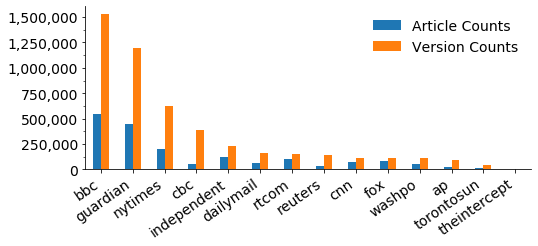

In [54]:
article_and_version_count_df = pd.concat([
    pd.Series(article_counts).to_frame('article_counts'),
    pd.Series(version_counts).to_frame('version_counts'),
], axis=1)


ax = article_and_version_count_df.sort_values('version_counts').iloc[::-1].plot(kind='bar', figsize=(8,3))

plt.legend(['Article Counts', 'Version Counts'], frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=35, horizontalalignment='right')

ax.yaxis.set_major_locator(MultipleLocator(250000))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(MultipleLocator(125000))

## Number of versions per article

In [ ]:
all_entry_vs = []
for n, conn in tqdm(conn_dict.items()):
    entry_vs = pd.read_sql('select count(1) as version_counts from entryversion group by entry_id', con=conn)
    entry_vs['source'] = n
    all_entry_vs.append(entry_vs)

In [79]:
all_entry_vs_df = pd.concat(all_entry_vs)

In [89]:
grouped = (
    all_entry_vs_df
        .groupby('source')
        .median()
        .sort_values(by='version_counts', ascending=False)
)

Text(0, 0.5, '')

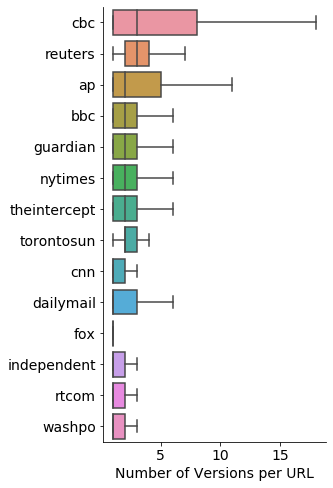

In [96]:
f, ax = plt.subplots(figsize=(4, 8))

ax = sns.boxplot(
    data=all_entry_vs_df,# .sort_values('version_counts'),
    x='version_counts',
    y='source',
    showfliers=False,
    order=grouped.index,
    ax=ax
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Number of Versions per URL')
plt.ylabel('')

# Collect Data From Datastore

In [2]:
from google.cloud import datastore
import os
from tqdm.auto import tqdm

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/alex/.google-cloud/usc-research-data-access.json'
client = datastore.Client()

In [4]:
types=[
    'edit-paths-sentence-stats',
#     'edit-paths-sentence-diffs',
#     'edit-paths-word-stats',
#     'edit-paths-word-diffs',
]

for t in types:
    q = client.query(kind=t)   
    results = q.fetch()
    num = results.num_results
    res_iter=iter(results)

#############if False:
#############     for res in tqdm(res_iter, total=num):
#############         client.delete(res.key)

sentence_stats = []
for res in tqdm(res_iter):
    sentence_stats.append(res)

0it [00:00, ?it/s]

In [5]:
import pandas as pd 
sentence_stats_df = pd.DataFrame(sentence_stats)

In [6]:
sentence_stats_df

,num_removed_sents,num_added_sents,len_new_doc,len_old_doc,version_old,a_id,source,version_new,num_changed_sents,status
0,0.0,0.0,35.0,35.0,0.0,1,ap,1.0,3.0,NaN
1,3.0,0.0,31.0,34.0,1.0,1,ap,2.0,12.0,NaN
2,32.0,25.0,31.0,38.0,0.0,10,ap,1.0,0.0,NaN
3,9.0,12.0,31.0,27.0,1.0,10,ap,2.0,8.0,NaN
4,29.0,2.0,5.0,32.0,2.0,10,ap,3.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1238696,0.0,0.0,131.0,131.0,0.0,989454,wp,1.0,2.0,NaN
1238697,0.0,1.0,95.0,94.0,0.0,994704,wp,1.0,2.0,NaN
1238698,0.0,3.0,168.0,165.0,0.0,995246,wp,1.0,10.0,NaN
1238699,0.0,2.0,170.0,168.0,1.0,995246,wp,2.0,0.0,NaN


In [7]:
name_mapper = {
    'bbc': 'bbc-1',
    'newssniffer-bbc': 'bbc-2',
    'newssniffer-guardian': 'guardian',
    'newssniffer-independent': 'independent',
    'newssniffer-nytimes': 'nyt',
    'newssniffer-washpo': 'wp',
}

In [10]:
articles_and_version_counts_plus_processed = pd.concat([
    sentence_stats_df['source'].value_counts().to_frame('processed version pairs'),
    sentence_stats_df.groupby('source')['a_id'].aggregate(set).str.len().to_frame('processed articles'),
    articles_and_versions.rename(index=lambda x: name_mapper.get(x, x))
], axis=1).fillna(0).apply(lambda s: s.astype(int))

NameError: name 'articles_and_versions' is not defined

In [9]:
articles_and_version_counts_plus_processed.head()

NameError: name 'articles_and_version_counts_plus_processed' is not defined

In [439]:
articles_and_version_counts_plus_processed[[
    'processed version pairs',
    'version_thresh_counts',
    'processed articles', 
    'article_thresh_counts'
]].assign(a_id_finished=lambda df: df['processed articles'] / df['article_thresh_counts']).sort_values('a_id_finished')

,processed version pairs,version_thresh_counts,processed articles,article_thresh_counts,a_id_finished
guardian,15741,843084,5742,231051,0.024852
bbc-2,49028,1238835,18051,307536,0.058696
nyt,20333,365897,6919,86955,0.079570
cbc,26460,314899,3201,38197,0.083802
torontostar,36127,154505,5209,26975,0.193105
ap,15523,74364,3100,12841,0.241414
dailymail,27088,98929,5910,23474,0.251768
reuters,45020,133922,7559,26530,0.284923
cnn,15956,59826,5944,19965,0.297721
bbc-1,16705,74592,8194,23782,0.344546


In [332]:
sentence_stats_df['num_added_sents'].value_counts()
# sentence_stats_df['num_changed'].value_counts()

sentence_stats_df['num_changed_sents'].value_counts().sort_index()

0.0       90603
1.0      103330
2.0       46191
3.0       25156
4.0       18450
          ...  
168.0         1
199.0         1
226.0         1
227.0         1
259.0         1
Name: num_changed_sents, Length: 122, dtype: int64

In [464]:
types=[
    'edit-paths-sentence-stats',
#     'edit-paths-sentence-diffs',
#     'edit-paths-word-stats',
#     'edit-paths-word-diffs',
]

outlet = ['telegraph']
outlet_sentence_stats = []

for o in outlet:
    print('outlet: %s' % o)
    for t in types:
        q = client.query(kind=t).add_filter('source', '=', o)
        results = q.fetch()
        num = results.num_results
        res_iter=iter(results)

    for res in tqdm(res_iter):
        outlet_sentence_stats.append(res)

outlet: telegraph


0it [00:00, ?it/s]

In [465]:
outlet_sentence_stats_df = pd.DataFrame(outlet_sentence_stats)

In [466]:
outlet_sentence_stats_df['a_id'].unique().shape

(25683,)

## Look at Washington Post Diffs

In [145]:
# sentence_diffs_df.to_csv('cache/wp-sentence-diffs.csv')
types=[
#     'edit-paths-sentence-stats',
    'edit-paths-sentence-diffs',
#     'edit-paths-word-stats',
#     'edit-paths-word-diffs',
]

for t in types:
    q = client.query(kind=t).add_filter('source', '=', 'wp')
    results = q.fetch()
    num = results.num_results
    res_iter=iter(results)

#############if False:
#############     for res in tqdm(res_iter, total=num):
#############         client.delete(res.key)

sentence_diffs = []
for res in tqdm(res_iter):
    sentence_diffs.append(res)

0it [00:00, ?it/s]

In [147]:
sentence_diffs_df = pd.DataFrame(sentence_diffs)

In [158]:
sentence_diffs_df['a_id'].unique()

array([1069407, 1069491, 1069513, ...,  929677,  929877,  934098])

In [173]:
col_order = [
    'key', 'a_id', 's_idx',  'version_old', 'version_new', 
    'source', 'sent_old', 'tag_old', 'tag_new', 'sent_new', 
]

In [163]:
sentence_diffs_df['key'] = (
    sentence_diffs_df['a_id'].astype(str) + '-' + 
    sentence_diffs_df['version_old'].astype(str) + '-' + 
    sentence_diffs_df['version_new'].astype(str)
)

In [337]:
import numpy as np 
import itertools

def condense_tags(t, num_bins=20, desired_tag='+'):
    """Take a list of tags of length k and compress it into a list of len `num_bins`."""
    bins = np.linspace(0, 1, num=num_bins+1)
    slots = np.linspace(0, 1, num=len(t))
    t_bins = np.digitize(slots, bins[:-1])
    output = np.zeros(num_bins) * np.nan
    for k, g in itertools.groupby(zip(t_bins, t), key=lambda x: x[0]):
        tag = 1 if any(map(lambda x: x[1] == desired_tag, g)) else 0
        output[k-1] = tag
    return output

In [293]:
position_added = (sentence_diffs_df
                  .groupby('key')
                  .apply(lambda df: 
                         df.sort_values('s_idx')
                          .loc[lambda df: df['sent_new'] != '']
                          ['tag_new']
                         .to_list()
                        )
                 )



In [342]:
position_removed = (sentence_diffs_df
                  .groupby('key')
                  .apply(lambda df: 
                         df.sort_values('s_idx')
                          .loc[lambda df: df['sent_new'] != '']
                          ['tag_old']
                         .to_list()
                        )
                 )

In [339]:
position_added_cond = (position_added
                       .apply(lambda x: pd.Series(condense_tags(x, num_bins=50, desired_tag='+')))
                       .T.fillna(method='ffill').T
                      )

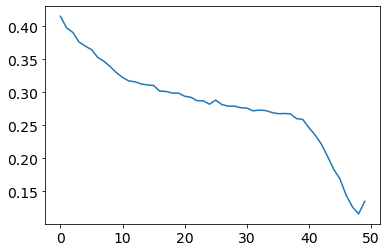

In [340]:
position_added_cond.mean().plot()

In [343]:
position_removed_cond = (position_removed
                       .apply(lambda x: pd.Series(condense_tags(x, num_bins=50, desired_tag='-')))
                       .T.fillna(method='ffill').T
                      )

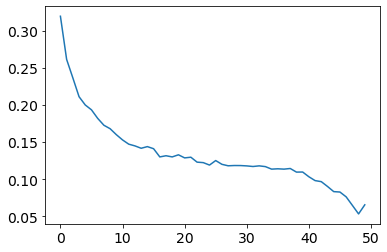

In [344]:
position_removed_cond.mean().plot()

In [396]:
desired_docs = (sentence_stats_df
 .loc[lambda df: df['source'] == 'wp']
  .loc[lambda df: df['num_added_sents'] == 1]
#  .loc[lambda df: df['num_added_sents'].isin([1, 2])]
 .loc[lambda df: df['num_changed_sents'] == 0]
 .loc[lambda df: df['num_removed_sents'] == 0]
)

In [416]:
desired_sentences = (sentence_diffs_df
 .loc[lambda df: df['key'].isin(desired_docs
 .pipe(lambda df: df.apply(lambda x: '%s-%s-%s' % (int(x['a_id']), int(x['version_old']), int(x['version_new'])), axis=1))
 )]
)

In [427]:
position_added = (desired_sentences.groupby('key')
  .apply(lambda df: df.sort_values('s_idx').loc[lambda df: df['sent_new'] != '']['tag_new'].to_list())
)

In [429]:
position_added

position_added_cond = (position_added
                       .apply(lambda x: pd.Series(condense_tags(x, num_bins=50, desired_tag='+')))
                       .T.fillna(method='ffill').T
                      )

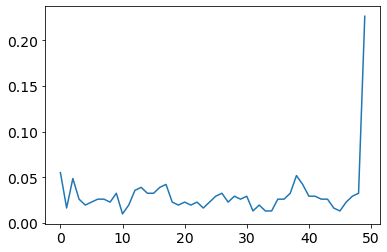

In [432]:
position_added_cond.mean().plot()

In [386]:
doc = (sentence_diffs_df
 .loc[lambda df: df['a_id'] == 1077063]
 .loc[lambda df: df['version_old'] == 1]
 .loc[lambda df: df['version_new'] == 2] 
)

In [362]:
doc = doc.sort_values('s_idx')

In [385]:
reload(unp)

<module 'util.util_newssniffer_parsing' from '../util/util_newssniffer_parsing.py'>

In [388]:
display(HTML(unp.html_compare_articles(df=doc)))

Old Version,New Version
NEW YORK—A wave of late selling pummeled U.S. stocks Friday and pushed the market to its worst week in four years.,NEW YORK—A wave of late selling pummeled U.S. stocks Friday and pushed the market to its worst week in four years.
The dismal start to the new year comes as investors worry that China’s huge economy is slowing down.,The dismal start to the new year comes as investors worry that China’s huge economy is slowing down.
"That has helped send the price of oil plunging to its lowest level since 2004, the latest blow to U.S. energy companies.","That has helped send the price of oil plunging to its lowest level since 2004, the latest blow to U.S. energy companies."
Industrial and technology companies such as Boeing and Apple that do a lot of business in China have also fallen sharply this week.,Industrial and technology companies such as Boeing and Apple that do a lot of business in China have also fallen sharply this week.
Mining companies such as Freeport-McMoRan plunged as copper prices have fallen.,Mining companies such as Freeport-McMoRan plunged as copper prices have fallen.
China is a major importer of copper.,China is a major importer of copper.
"Stocks started the day higher, driven in part by news of an encouraging burst in hiring last month by U.S. employers.","Stocks started the day higher, driven in part by news of an encouraging burst in hiring last month by U.S. employers."
"China’s stock market also rose 2 percent overnight, recovering somewhat after steep drops earlier in the week triggered trading halts.","China’s stock market also rose 2 percent overnight, recovering somewhat after steep drops earlier in the week triggered trading halts."
"Indexes wavered between small gains and losses for most of the day, but took a decisive turn lower in the last hour of trading.","Indexes wavered between small gains and losses for most of the day, but took a decisive turn lower in the last hour of trading."
"That made this the worst week since September 2011, when the market was roiled by the fight over the U.S. debt ceiling and Standard & Poor’s move to cut the credit rating of the U.S. government.","That made this the worst week since September 2011, when the market was roiled by the fight over the U.S. debt ceiling and Standard & Poor’s move to cut the credit rating of the U.S. government."


In [371]:
doc[['sent_old', 'sent_new']].pipe(lambda df: unp.html_compare_articles(df['sent_old'], df['sent_new']))

TypeError: string indices must be integers

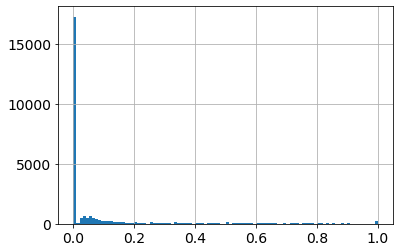

In [156]:
(sentence_stats_df
 .loc[lambda df: df['source'] == 'reuters']
 .pipe(lambda df: df['num_added_sents'] / df['len_new_doc'])
 .hist(bins=100)
)

In [13]:
q = client.query(kind=t).add_filter('source', '=', 'bbc-1')

In [14]:
r = list(q.fetch())

In [15]:
pd.DataFrame(r)

,len_old_doc,num_changed_sents,source,num_removed_sents,len_new_doc,version_new,num_added_sents,a_id,version_old
0,38,2,bbc-1,1,40,1.0,3,1,0.0
1,40,3,bbc-1,0,51,2.0,11,1,1.0
2,53,1,bbc-1,0,53,3.0,0,1,2.0
3,53,4,bbc-1,3,55,4.0,5,1,3.0
4,55,5,bbc-1,3,55,5.0,3,1,4.0
5,55,3,bbc-1,0,68,6.0,13,1,5.0
6,60,19,bbc-1,23,51,7.0,14,1,6.0
7,46,9,bbc-1,0,46,8.0,0,1,7.0
8,20,4,bbc-1,6,20,1.0,6,11,0.0
9,52,10,bbc-1,1,51,1.0,0,11772,0.0


# Plot Sentence-Level Statistics

In [ ]:
import sqlite3
import pandas as pd 
import os
import glob
import matplotlib.pyplot as plt

[]

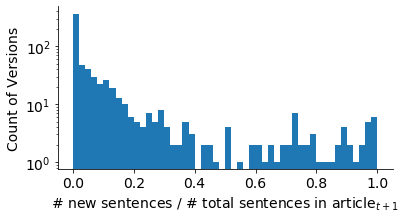

In [676]:
ax = (sentence_stats_df
 .pipe(lambda df: df['num_added_sents'] / (df['len_new_doc']))
 .hist(bins=50, figsize=(6, 3))
)
plt.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Count of Versions')
plt.xlabel('# new sentences / # total sentences in article$_{t+1}$')
plt.semilogy()

[]

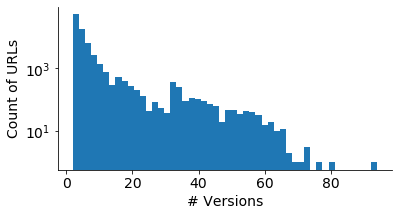

In [712]:
reut_versions_per_article = pd.read_sql(
    'select entry_id, Count(1) from entryversion group by entry_id',
    con=conn_dict['reuters']
)

ax = nyt_versions_per_article['Count(1)'].hist(bins=50, figsize=(6, 3))
plt.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Count of URLs')
plt.xlabel('# Versions')

plt.semilogy()